In [2]:
# Loading the packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Get Bitcoin data
def get_bitcoin_price():
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        "vs_currency": "usd",
        "days": "365",  # Change this to the number of days you want
        "interval": "daily"
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        df = pd.DataFrame(prices, columns=["timestamp", "price"])
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
        return df
    else:
        print("Error fetching data:", response.status_code)
        return None

# Example usage
if __name__ == "__main__":
    btc_data = get_bitcoin_price()
    if btc_data is not None:
        print(btc_data.head())

print(btc_data)

   timestamp         price
0 2024-03-10  68508.003963
1 2024-03-11  69075.666882
2 2024-03-12  72130.553008
3 2024-03-13  71467.173503
4 2024-03-14  73097.767027
              timestamp         price
0   2024-03-10 00:00:00  68508.003963
1   2024-03-11 00:00:00  69075.666882
2   2024-03-12 00:00:00  72130.553008
3   2024-03-13 00:00:00  71467.173503
4   2024-03-14 00:00:00  73097.767027
..                  ...           ...
361 2025-03-06 00:00:00  90604.080985
362 2025-03-07 00:00:00  90001.400876
363 2025-03-08 00:00:00  86773.335976
364 2025-03-09 00:00:00  86142.983359
365 2025-03-09 19:01:33  82704.271745

[366 rows x 2 columns]


In [4]:

# Get Ethereum data
def get_ethereum_price():
    url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart"
    params = {
        "vs_currency": "usd",
        "days": "365",  # Change this to the number of days you want
        "interval": "daily"
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        df = pd.DataFrame(prices, columns=["timestamp", "price"])
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
        return df
    else:
        print("Error fetching data:", response.status_code)
        return None

# Example usage
if __name__ == "__main__":
    eth_data = get_ethereum_price()
    if eth_data is not None:
        print(eth_data.head())

print(eth_data)

   timestamp        price
0 2024-03-10  3916.041188
1 2024-03-11  3887.473105
2 2024-03-12  4070.604075
3 2024-03-13  3978.685771
4 2024-03-14  4007.912126
              timestamp        price
0   2024-03-10 00:00:00  3916.041188
1   2024-03-11 00:00:00  3887.473105
2   2024-03-12 00:00:00  4070.604075
3   2024-03-13 00:00:00  3978.685771
4   2024-03-14 00:00:00  4007.912126
..                  ...          ...
361 2025-03-06 00:00:00  2241.384115
362 2025-03-07 00:00:00  2202.320736
363 2025-03-08 00:00:00  2140.749809
364 2025-03-09 00:00:00  2199.999500
365 2025-03-09 19:01:43  2023.104372

[366 rows x 2 columns]


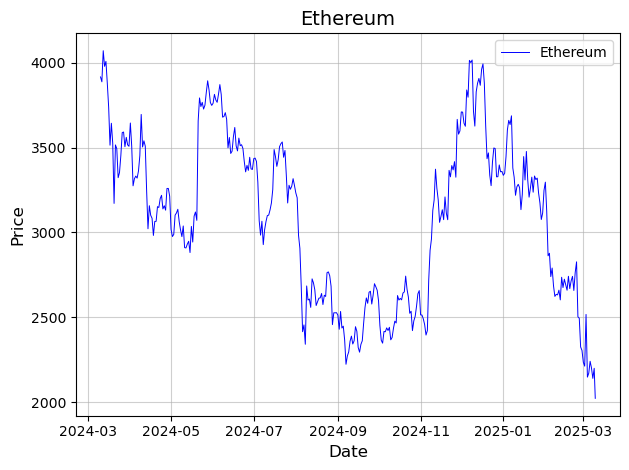

In [5]:
# Ethereum
plt.plot(eth_data['timestamp'], 
         eth_data['price'], 
         label='Ethereum', 
         color='blue', 
         linewidth=0.7)


plt.title('Ethereum', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Define a function to apply transformations on each group
def add_features(group):
    # Create lagged features
    group['price_lag_1'] = group['price'].shift(1)
    group['price_lag_2'] = group['price'].shift(2)
    group['price_lag_5'] = group['price'].shift(5)

    # Create moving averages (2-day, 4-day)
    group['MA_2'] = group['price'].rolling(window=2).mean()
    group['MA_4'] = group['price'].rolling(window=4).mean()

    # Rolling standard deviation (volatility) over 3 days
    group['Volatility_10'] = group['price'].rolling(window=3).std()

    # Daily returns as a feature
    group['Daily_Return'] = group['price'].pct_change()

    # Relative Strength Index (RSI)
    def RSI(series, period=14):
        delta = series.diff(1)
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)
        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    group['RSI_14'] = RSI(group['price'])

    # MACD (Moving Average Convergence Divergence)
    short_ema = group['price'].ewm(span=12, adjust=False).mean()
    long_ema = group['price'].ewm(span=26, adjust=False).mean()
    group['MACD'] = short_ema - long_ema
    group['Signal_Line'] = group['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands (20-day MA and 2 std devs)
   # group['BB_Middle'] = group['price'].rolling(window=20).mean()
   # group['BB_Upper'] = group['BB_Middle'] + 2 * group['price'].rolling(window=20).std()
   # group['BB_Lower'] = group['BB_Middle'] - 2 * group['price'].rolling(window=20).std()

    # Stochastic Oscillator (%K and %D)
 #   low_14 = group['Low'].rolling(window=14).min()
 #   high_14 = group['High'].rolling(window=14).max()
 #   group['Stochastic_%K'] = 100 * (group['price'] - low_14) / (high_14 - low_14)
 #   group['Stochastic_%D'] = group['Stochastic_%K'].rolling(window=3).mean()

    return group

In [15]:
add_features(eth_data)

,timestamp,price,price_lag_1,price_lag_2,price_lag_5,MA_5,MA_10,MA_20,Volatility_10,Daily_Return,RSI_14,MACD,Signal_Line,BB_Middle,BB_Upper,BB_Lower
0,2024-03-10 00:00:00,3916.041188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2024-03-11 00:00:00,3887.473105,3916.041188,NaN,NaN,3901.757146,NaN,NaN,NaN,-0.007295,NaN,-2.278935,-0.455787,NaN,NaN,NaN
2,2024-03-12 00:00:00,4070.604075,3887.473105,3916.041188,NaN,3979.038590,NaN,NaN,98.524763,0.047108,NaN,10.570283,1.749427,NaN,NaN,NaN
3,2024-03-13 00:00:00,3978.685771,4070.604075,3887.473105,NaN,4024.644923,3963.201035,NaN,91.565712,-0.022581,NaN,13.184361,4.036414,NaN,NaN,NaN
4,2024-03-14 00:00:00,4007.912126,3978.685771,4070.604075,NaN,3993.298949,3986.168769,NaN,46.963523,0.007346,NaN,17.413626,6.711856,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2025-03-06 00:00:00,2241.384115,2171.496944,2148.199533,2235.204209,2206.440529,2269.604708,2517.555881,48.494591,0.032184,35.741051,-173.924701,-154.769871,2517.555881,2981.072563,2054.039199
362,2025-03-07 00:00:00,2202.320736,2241.384115,2171.496944,2212.824351,2221.852426,2190.850332,2491.438426,35.024445,-0.017428,33.876745,-174.049431,-158.625783,2491.438426,2964.582717,2018.294135
363,2025-03-08 00:00:00,2140.749809,2202.320736,2241.384115,2517.338239,2171.535273,2188.987901,2463.834847,50.734916,-0.027957,34.321589,-177.075326,-162.315692,2463.834847,2951.697960,1975.971735
364,2025-03-09 00:00:00,2199.999500,2140.749809,2202.320736,2148.199533,2170.374655,2196.113540,2440.839735,34.897214,0.027677,32.406881,-172.701617,-164.392877,2440.839735,2933.125667,1948.553802
